<a href="https://colab.research.google.com/github/Gee743/Facial_Emotion_Recognition/blob/main/G21235963_CK_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from skimage.feature import local_binary_pattern
from google.colab import drive

drive.mount('/content/drive')

# Load the Face Detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [102]:
def load_and_detect_faces(folder_path, is_training=True):
    images = []
    labels = []
    # CLAHE is used for local facial features
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))


    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):
            file_list = os.listdir(label_path)

            for img_file in file_list:
                img_path = os.path.join(label_path, img_file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                if img is not None:
                    #Gaussian Blur to remove digital noise
                    img = cv2.GaussianBlur(img, (3, 3), 0)

                    faces = face_cascade.detectMultiScale(img, 1.1, 5)
                    for (x, y, w, h) in faces:
                        face_region = img[y:y+h, x:x+w]
                        face_region = cv2.resize(face_region, (64, 64))
                        face_region = clahe.apply(face_region)

                        images.append(face_region)
                        labels.append(label)

                        # Data Augmentation for the smaller class
                        if is_training and label in ['fear']:
                            flipped_face = cv2.flip(face_region, 1) # Horizontal flip
                            images.append(flipped_face)
                            labels.append(label)

    return images, labels

# LBP Parameters
radius = 2
n_points = 8 * radius


def extract_lbp_features(images):
    lbp_features = []
    for img in images:
        lbp = local_binary_pattern(img, n_points, radius, method="uniform")
        (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6) # Normalization
        lbp_features.append(hist)
    return np.array(lbp_features)

In [104]:
# Loading Data
train_path = '/content/drive/My Drive/CK_Data/train'
test_path = '/content/drive/My Drive/CK_Data/test'

X_train_raw, y_train = load_and_detect_faces(train_path)
X_test_raw, y_test = load_and_detect_faces(test_path)

X_train = extract_lbp_features(X_train_raw)
X_test = extract_lbp_features(X_test_raw)

svm_model = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=100, gamma=0.1, class_weight='balanced'))
svm_model.fit(X_train, y_train)

print("Model Training Complete.")

Model Training Complete.


In [41]:
# Predictions
y_pred = svm_model.predict(X_test)

# Accuracy
print(f"Total Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")

# Detailed Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Total Accuracy: 40.00%

Classification Report:
              precision    recall  f1-score   support

       anger       0.24      0.22      0.23        18
        fear       0.00      0.00      0.00        14
       happy       0.41      0.40      0.41        30
     neutral       0.47      0.53      0.50        36
     sadness       0.29      0.29      0.29        17
    surprise       0.44      0.57      0.50        35

    accuracy                           0.40       150
   macro avg       0.31      0.34      0.32       150
weighted avg       0.36      0.40      0.38       150


Confusion Matrix:
[[ 4  0  1  5  3  5]
 [ 2  0  2  4  4  2]
 [ 6  0 12  3  2  7]
 [ 3  0  5 19  2  7]
 [ 0  1  5  2  5  4]
 [ 2  1  4  7  1 20]]


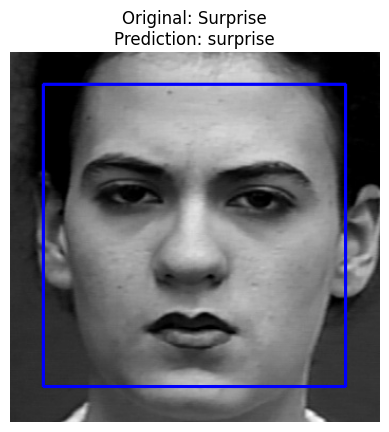

In [99]:
def predict_emotion(image_path, original_label):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 5)

    for (x, y, w, h) in faces:
        face = gray[y:y+h, x:x+w]
        face = cv2.resize(face, (32, 32))
        face = cv2.GaussianBlur(face, (3, 3), 0)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        face = clahe.apply(face)

        features = extract_lbp_features([face])
        prediction = svm_model.predict(features)[0]

        # Draw the square
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)



    # Set the title as Original vs Prediction
    plt.title(f"Original: {original_label}\nPrediction: {prediction}")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

predict_emotion('/content/drive/My Drive/CK_Data/test/neutral/107.jpg', 'Surprise')

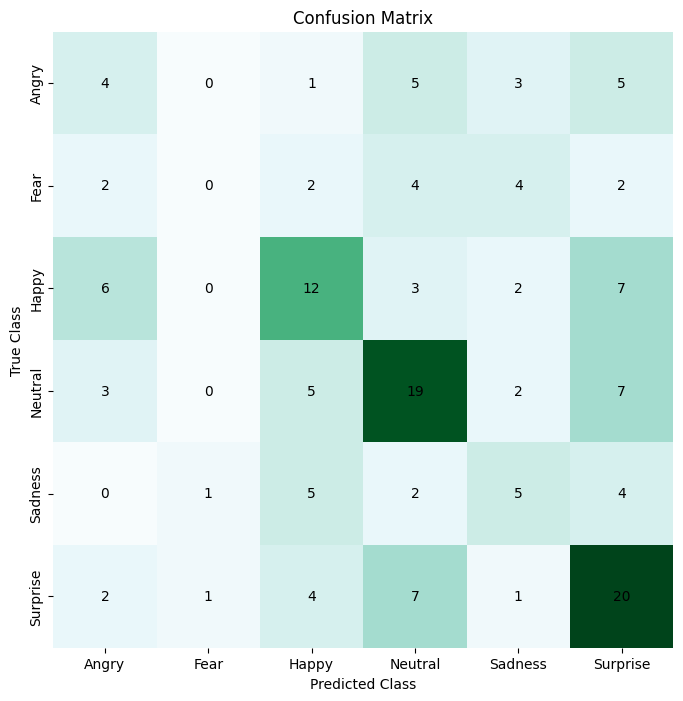

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

class_names = ["Angry", "Fear", "Happy", "Neutral", "Sadness", "Surprise"]

conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate percentages
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100

# Plot confusion matrix with class names
plt.figure(figsize=(8, 8))
ax = sns.heatmap(conf_matrix, annot=False, cmap="BuGn", xticklabels=class_names, yticklabels=class_names, cbar=False)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        count = conf_matrix[i, j]
        ax.text(j + 0.5, i + 0.5, f"{count}", ha="center", va="center", color="black", fontsize=10)

plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()